In [41]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
client_data = pd.read_csv('client_data.csv')
price_data = pd.read_csv('price_data.csv')

### Feature Engineering

#### We need to end up with a dataset of client contract features and client price features. One concern is how to aggregate the price data for each customer. Given that multiple variables concerning each customer's prices for one year is given, we can merge the two datasets by aggregating such price data and creating meaningful features for each contract.

In [43]:
price_data = price_data.sort_values(['id', 'price_date'])
date_counts = price_data.groupby('id').agg({'price_date': 'count'}).add_prefix('count_')
date_counts = date_counts[date_counts['count_price_date'] != 12]
date_counts

,count_price_date
id,
0117022254b01c36da23c5329a97e653,11
02bc81ecebcc8328dba4bf07bd6b6d55,11
0580216fd8b3a562087d52673f6ba63d,11
07cf5cb6081706df0be8b5512bc18000,10
0e7e0352b2dc0c2d5576bd9daaa4c609,11
...,...
f7aed20b79f48e9e87687dc74fc6a353,9
f7d547f426e3152fc24d151f6062e39f,11
fa751947c16fdc80c0c52a88c09df546,11


106 clients do not have price data for all months. Will be dropping these from the analysis to ensure variable meanings are consistent across all clients.

In [44]:
price_data = price_data[~price_data['id'].isin(date_counts.index.tolist())]

#### Feature Engineering on price_data. We will be using various aggregation methods to convert each client's price data into a stream of meaningful features.

In [45]:
grouped_price = price_data.groupby(['id'])
ids = grouped_price.size().index
price_aggs = pd.DataFrame({'id': ids})
pcols = price_data.columns[2:]

# Mean and normalized variation of prices.
means = grouped_price.agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
    }).add_prefix('mean_')

stdevs = grouped_price.agg({
    'price_off_peak_var': 'std', 
    'price_peak_var': 'std', 
    'price_mid_peak_var': 'std',
    'price_off_peak_fix': 'std',
    'price_peak_fix': 'std',
    'price_mid_peak_fix': 'std'   
    }).add_prefix('std_')

norm_var = pd.merge(stdevs, means, on='id')
norm_var = norm_var.eval(f'''
    var_norm_price_off_peak_var = mean_price_off_peak_var / std_price_off_peak_var.where((mean_price_off_peak_var != 0) & (std_price_off_peak_var != 0))
    var_norm_price_peak_var = mean_price_peak_var / std_price_peak_var.where((mean_price_peak_var != 0) & (std_price_peak_var != 0))
    var_norm_price_mid_peak_var = mean_price_mid_peak_var / std_price_mid_peak_var.where((mean_price_mid_peak_var != 0) & (std_price_mid_peak_var != 0))
    var_norm_price_off_peak_fix = mean_price_off_peak_fix / std_price_off_peak_fix.where((mean_price_off_peak_fix != 0) & (std_price_off_peak_fix != 0))
    var_norm_price_peak_fix = mean_price_peak_fix / std_price_peak_fix.where((mean_price_peak_fix != 0) & (std_price_peak_fix != 0))
    var_norm_price_mid_peak_fix = mean_price_mid_peak_fix / std_price_mid_peak_fix.where((mean_price_mid_peak_fix != 0) & (std_price_mid_peak_fix != 0))
               ''').drop(norm_var.columns, axis=1)

price_aggs = pd.merge(price_aggs, means, on='id', how='outer')
price_aggs = pd.merge(price_aggs, norm_var, on='id', how='outer')

# Mean price ratios between consecutive periods.
price_aggs.eval(f'''
    ratio_mean_price_off_peak_peak_var = mean_price_off_peak_var / mean_price_peak_var.where((mean_price_off_peak_var != 0) & (mean_price_peak_var != 0))
    ratio_mean_price_peak_mid_peak_var = mean_price_peak_var / mean_price_mid_peak_var.where((mean_price_peak_var != 0) & (mean_price_mid_peak_var != 0))
    ratio_mean_price_off_peak_mid_peak_var = mean_price_off_peak_var / mean_price_mid_peak_var.where((mean_price_off_peak_var != 0) & (mean_price_mid_peak_var != 0))
    ratio_mean_price_off_peak_peak_fix = mean_price_off_peak_fix / mean_price_peak_fix.where((mean_price_off_peak_fix != 0) & (mean_price_peak_fix != 0))
    ratio_mean_price_peak_mid_peak_fix = mean_price_peak_fix / mean_price_mid_peak_fix.where((mean_price_peak_fix != 0) & (mean_price_mid_peak_fix != 0))
    ratio_mean_price_off_peak_mid_peak_fix = mean_price_off_peak_fix / mean_price_mid_peak_fix.where((mean_price_off_peak_fix != 0) & (mean_price_mid_peak_fix != 0))
    ''', inplace=True)

# Max percetange spike in price from month to month.
price_aggs = pd.merge(price_aggs, price_data.eval(f'''
    spike_price_off_peak_var = price_off_peak_var.pct_change().where(price_off_peak_var != 0)
    spike_price_peak_var = price_peak_var.pct_change().where(price_peak_var != 0)
    spike_price_mid_peak_var = price_mid_peak_var.pct_change().where(price_mid_peak_var != 0)
    spike_price_off_peak_fix = price_off_peak_fix.pct_change().where(price_off_peak_fix != 0)
    spike_price_peak_fix = price_peak_fix.pct_change().where(price_peak_fix != 0)
    spike_price_mid_peak_fix = price_mid_peak_fix.pct_change().where(price_mid_peak_fix != 0)
    ''').drop(pcols, axis=1)[price_data['price_date'] != '2015-01-01'].groupby('id').agg({
        'spike_price_off_peak_var': 'max',
        'spike_price_peak_var': 'max',
        'spike_price_mid_peak_var': 'max',
        'spike_price_off_peak_fix': 'max',
        'spike_price_peak_fix': 'max',
        'spike_price_mid_peak_fix': 'max'
    }).add_prefix('max_'), on='id', how='outer')

# Percent change in price from first to last month
janprice, decprice = grouped_price.first().iloc[:,1:], grouped_price.last().iloc[:,1:]
janprice, decprice = janprice.where(janprice != 0), decprice.where(decprice != 0)
price_changes = ((janprice - decprice) / decprice).add_prefix('pct_chg_yr_')
price_aggs = pd.merge(price_aggs, price_changes, on='id', how='outer')


<span style="opacity: 0.5; font-size: 14px;">(Code is extremely optimized for large datasets, readability may be slightly impacted)</span>

### Feature Engineering on client_data.

In [46]:
# Quantitative features
client_data = client_data.eval('''
    current_cons_trend = cons_last_month * 12 / cons_12m.where(cons_12m != 0)
    ''')

# Normalizing variances with ln
client_data['ln_cons_12m'] = np.log(client_data['cons_12m'] + 1)
client_data['ln_cons_gas_12m'] = np.log(client_data['cons_gas_12m'] + 1)
client_data['ln_cons_last_month'] = np.log(client_data['cons_last_month'] + 1)
client_data['ln_forecast_cons_12m'] = np.log(client_data['forecast_cons_12m'] + 1)
client_data['ln_forecast_cons_year'] = np.log(client_data['forecast_cons_year'] + 1)
client_data['ln_forecast_meter_rent_12m'] = np.log(client_data['forecast_meter_rent_12m'] + 1)
client_data['ln_imp_cons'] = np.log(client_data['imp_cons'] + 1)

# Time-based features
client_data['date_activ'] = pd.to_datetime(client_data['date_activ'], format='%Y-%m-%d')
client_data['date_end'] = pd.to_datetime(client_data['date_end'], format='%Y-%m-%d')
client_data['date_modif_prod'] = pd.to_datetime(client_data['date_modif_prod'], format='%Y-%m-%d')
client_data['date_renewal'] = pd.to_datetime(client_data['date_renewal'], format='%Y-%m-%d')

client_data['weeks_since_renewal'] = ((dt.datetime.fromisoformat('2016-01-28') - client_data['date_renewal']).dt.days/7).astype(int)
client_data['tenure_weeks'] = ((dt.datetime.fromisoformat('2016-01-28') - client_data['date_activ']).dt.days/7).astype(int)
client_data['product_age_weeks'] = ((dt.datetime.fromisoformat('2016-01-28') - client_data['date_modif_prod']).dt.days/7).astype(int)
client_data['weeks_to_end'] = ((client_data['date_end'] - dt.datetime.fromisoformat('2016-01-28')).dt.days/7).astype(int)

# Mapping t/f to 1/0
mapper = {'t':1, 'f':0}
client_data['has_gas'] = client_data['has_gas'].map(mapper)

# Converting categorical data to numerical
client_data['f_channel_sales'] = pd.factorize(client_data['channel_sales'])[0]
client_data['f_origin_up'] = pd.factorize(client_data['origin_up'])[0]

### Correlations

In [47]:
data = pd.merge(client_data, price_aggs, on='id')
data = data.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], axis=1)

corrcols = data.columns.tolist()
corrcols.remove('channel_sales'); corrcols.remove('origin_up'); corrcols.remove('id')

In [48]:
corrs = data[corrcols].corr()

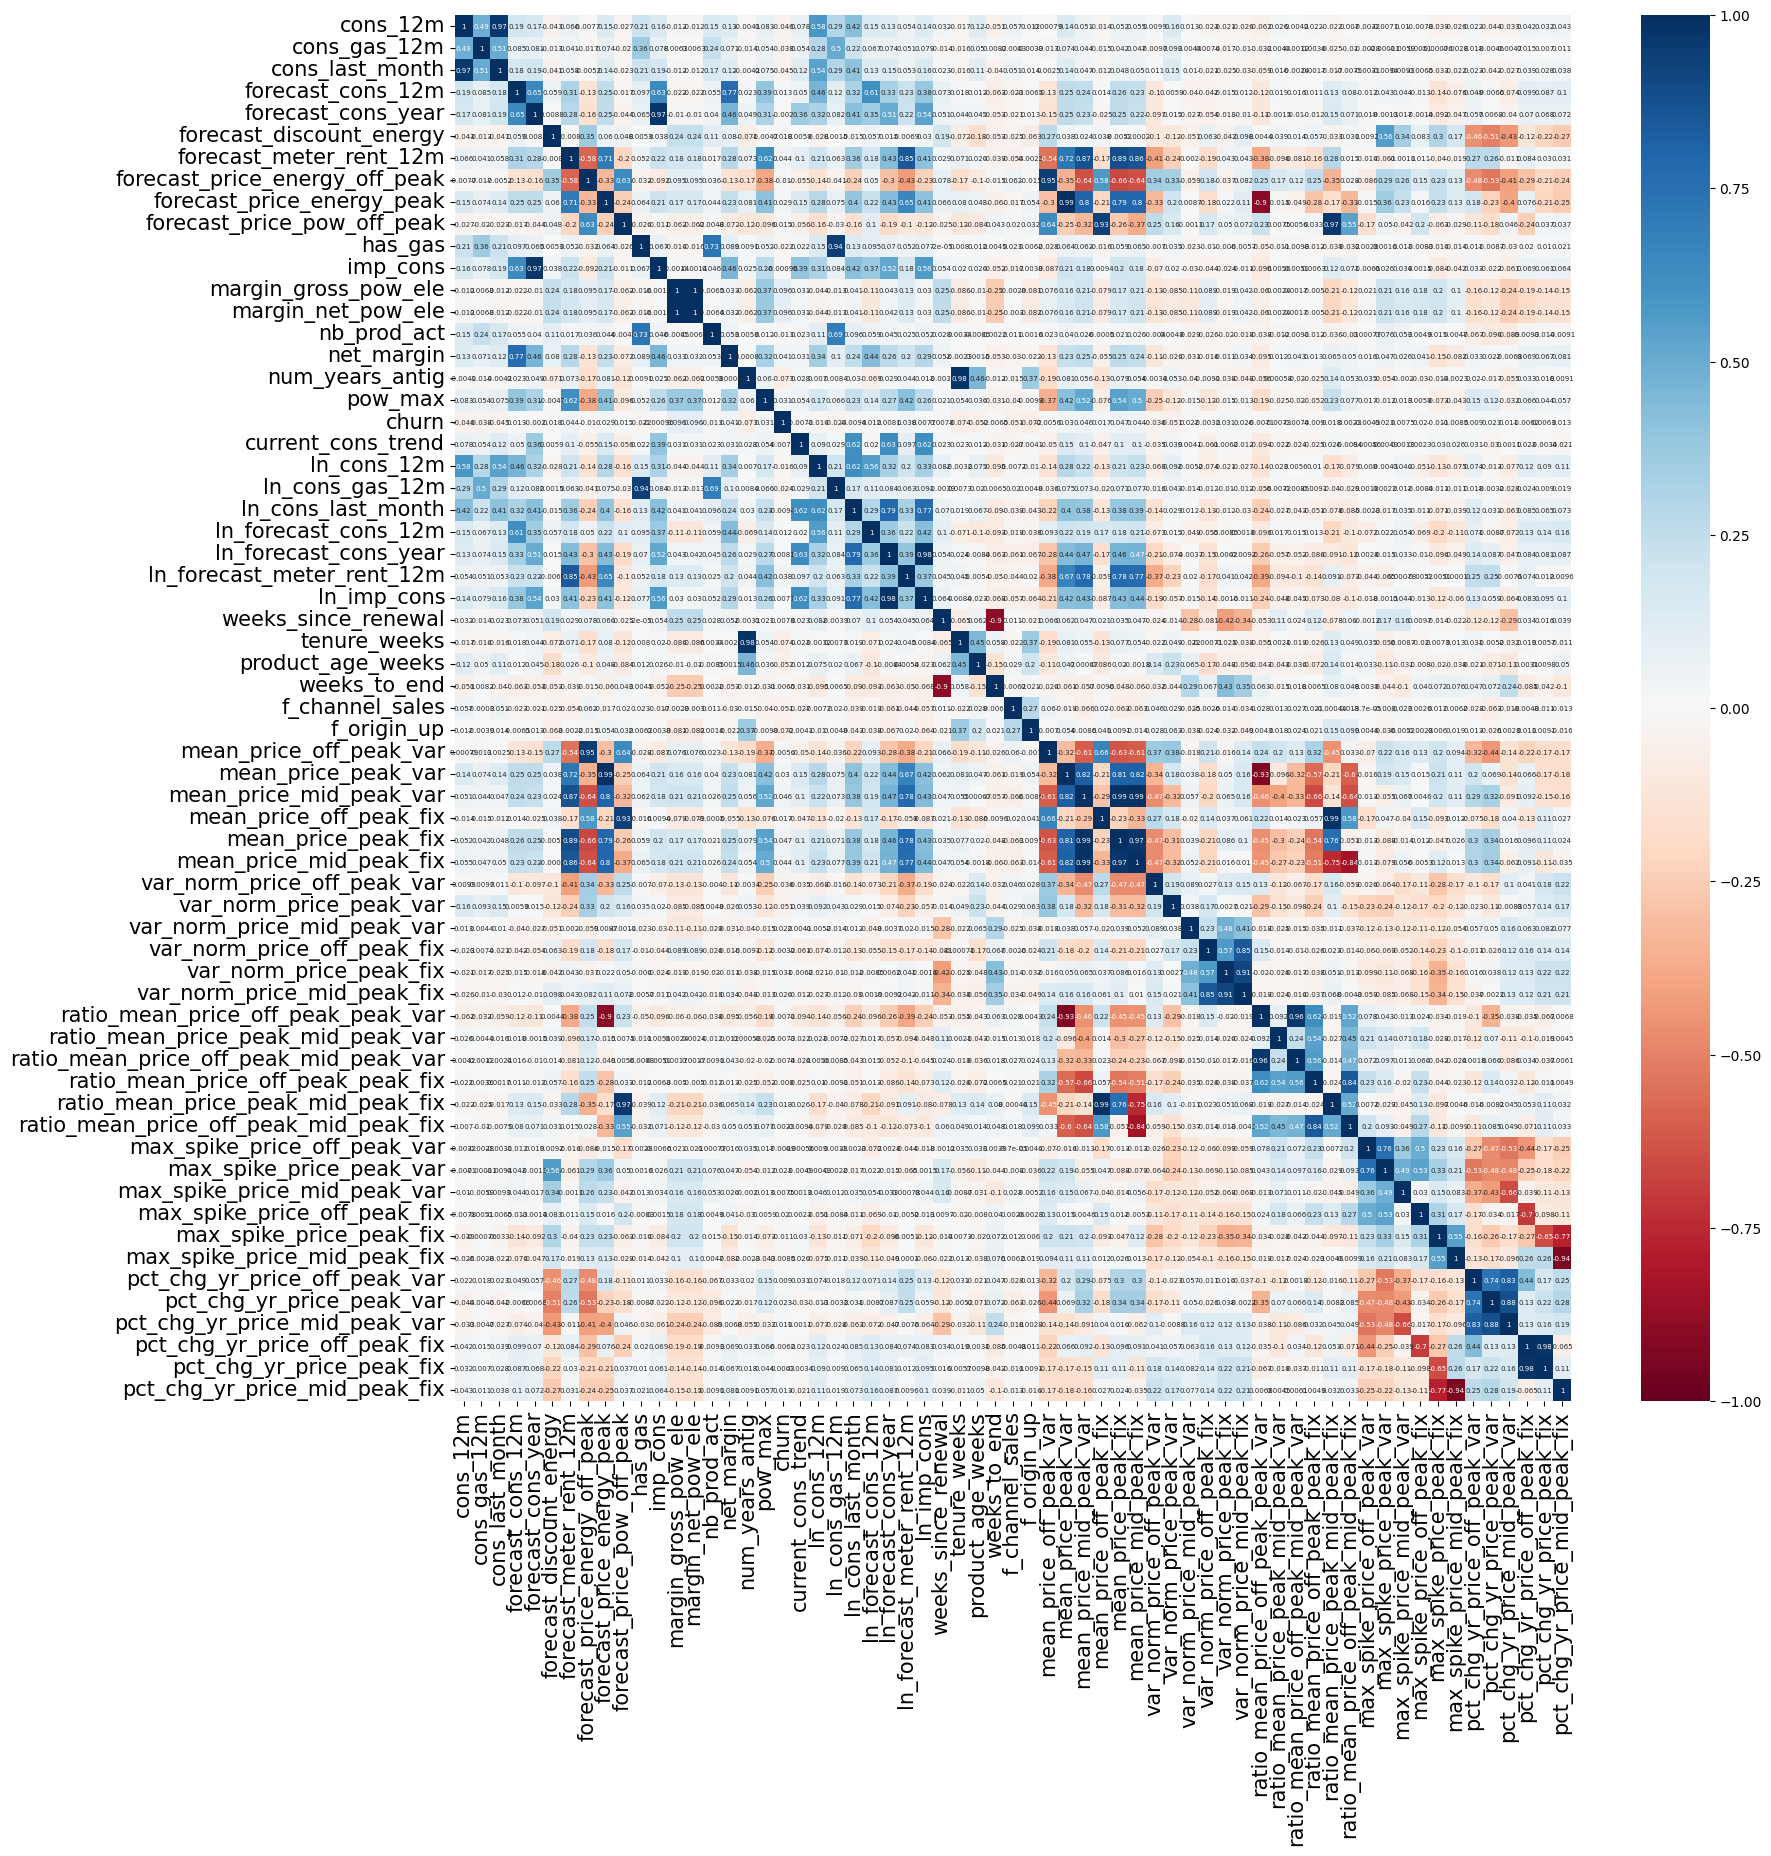

In [49]:
plt.figure(figsize=(18,18))
sns.heatmap(
    corrs,
    annot=True,
    annot_kws={'size': 5},
    cmap='RdBu',
    vmax=1,
    vmin=-1,
    center=0
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Many redundant variables. Although random forests can handle collinearity, we will be dropping some of these that may confound interpretability in the model's performance metrics.

### Finalized dataset

#### We have missing values due to the missing values encoded as 0 in some variables. These will be encoded as -2, as that value lies outside of the range of all variables, and it can be handled by random forest decision trees.

In [50]:
dataset = pd.merge(client_data, price_aggs, on='id', how='inner')
dataset.fillna(-2, inplace=True)
dataset.replace([np.inf, -np.inf], -2, inplace=True)

dataset.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], axis=1, inplace=True)
dataset.drop(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'f_origin_up',
              'forecast_meter_rent_12m', 'imp_cons', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
              'forecast_price_pow_off_peak', 'margin_gross_pow_ele', 'num_years_antig', 'ln_forecast_cons_year', 'f_channel_sales'], axis=1, inplace=True)

dataset.to_csv('churn_dataset.csv', index=False)